# Final assignment

In this project we are going to investigate courses at the Techincal University of Denmark. In the investigation we will focus our research on sentiment analysis of the content text describing each course. Using [API](https://kurser.dtu.dk/coursewebservicev2/course.asmx) we can get access to this and many other informations from https://kurser.dtu.dk/.   

Further we will focus on the departments providing the courses and apply community detection.  

First we will create the network, adding attribute and look at statistics. Later we will look into the sentiments assigned and afterwards do an analysis of communities. At last we will do term frequency–inverse document frequency (TF-IDF) and create wordclouds. 

In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

import re
import os
import math
import nltk
import codecs
import pathlib
import operator
import requests
import xmltodict
import numpy as np
import networkx as nx
import pandas as pd #1.5.1
from nltk import FreqDist
from fa2 import ForceAtlas2
from statistics import mode
import scipy.stats as stats
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from operator import itemgetter
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import xml.etree.ElementTree as ET
import matplotlib.colors as mcolors
import community #install python-louvain
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True);
nltk.download('wordnet', quiet=True);
nltk.download('omw-1.4', quiet=True);
pd.set_option('max_colwidth', 1000);
seed = 17

from urllib.parse import urljoin
import webbrowser

# import functions from https://github.com/x4nth055/pythoncode-tutorials/tree/master/web-scraping/extract-and-fill-forms
from form_extractor import get_all_forms, get_form_details, session

# All functions made to create the network is saved in the network_functions.py file (imported to this notebook)
from network_functions import *

# from pprint import pprint
# import sys

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Create network

First off we are going to create the network consisting of courses at DTU as nodes. Further we are linking courses to each other in a directed manner. Looking at the course page for each course we can find (if any) the prerequisities for taking each course. In-degrees means that it's recommended to take this course before signing up for the one looking at. Opposite is the out-degree. 
 
All this information is found using API from CampusNet at DTU.

### Add nodes to network

First thing is to add nodes to our network. Nodes are added, as explained, found from CampusNet to the directed graph. Below is the code that was used to find course codes from year group 2022/2023 and add it to the network.

```
#search for all courses in the course base with CourseCatalogVersion 2022/2023
link = "http://kurser.dtu.dk/coursewebservicev2/course.asmx/SearchDtuShb_Full?courseCode=&searchWords=&department=&teachingPeriod=&CourseCatalogVersion=2022/2023&courseCodeStart=&teachingLanguage=&courseIDList=&resultType=&education=&CourseType=&MasterRegular=&openUniversity=&textStudieboksen="
response = requests.request("GET", link)
course_ids = list(pd.read_xml(response.text)['int'])

#create graph
G = nx.DiGraph()

#search for course codes using the course id's
#append course codes to graph
for courseid in course_ids:
    course_code = convert_course_id(courseid)
    
    #add node to network
    G.add_node(course_code)
```

### Add links to network

Prerequisites for courses are here used to create links in-between. When looking for these we use the API. Often multiple alternatives for courses as prerequisite is stated, but sometimes you just need to have taken multiple courses. In the following an attribute 'No. pre-requisites' is created by counting the amount of courses you have to take before signing up to the course. For example for course 02635 will get a value of 2 and not 4 because of the punctuation: 
**Recommended prerequisites** 02525/02631/02633.02601



Below is the code that were used to create edges in the network and add the attribute 'No. pre-requisites'.

```
#collect all prerequisites for the courses
df = pd.DataFrame({'course': [], 'pre_req_raw': []})
course_numbers = [course[:5] for course in DTU_courses]
for course in course_numbers:
  pre_req = get_course_prerequisites(course)
  a_list = [course, pre_req]
  df.loc[len(df)] = a_list
```

```
#add edges to nodes
for i in range(len(DTU_courses)):
    node = DTU_courses[i][:5]
    
    #create prerequisites as list
    pre_req = df.iloc[i]['pre_req_raw']
    
    #collect how many actual pre-requisites that is needed for a course
    actual_prereq = 0
    actual_prereq = pre_req.count('.') + 1
    
    #divide string of prereq into list
    pre_req = pre_req.replace("/",",").replace(".",",").replace("(","").replace(")","").replace(" ","").split(",")

    if pre_req != ['']:
        acc_req = []
        for req in pre_req:
            if req in G.nodes():
                acc_req.append(req)
                
                #add attribute of actual amount of pre-requisites needed
                G.nodes()[DTU_courses[i]]['No. pre-requisites'] = actual_prereq
        
        if acc_req !=[]:
            #create link list
            new_edges = [(course, node) for course in acc_req]

            #add edges
            G.add_edges_from(new_edges)
```

This network was saved as a .gpickle file and is loaded here in order to run the notebook way faster!

In [2]:
# Import network from gpickle file
path = 'DTU_courses_network.gpickle'
G = nx.read_gpickle(path)

all_courses = list(G.nodes())

The nodes in the network are now connected.

### Add attributes to network

#### Departments, program and course size

Using the same API as before when finding the prerequisities, we can also add attributes such as department, amount of ECTS points and program type.  

First we find all departments and institutes.

In [3]:
# Define URL for departments
url = "https://kurser.dtu.dk/coursewebservicev2/course.asmx/GetDepartments?" 
response = requests.request("GET", url)

dict_data = xmltodict.parse(response.content)
department_count = len(dict_data['root']['item'])

# Create dictionary where keys are department name and value are department ID
dtu_department = dict()
dep_dict = dict()
for dep in range(department_count):
    dtu_department[dict_data['root']['item'][dep]['@en-gb']] = dict_data['root']['item'][dep]['@value']
    dep_dict[dict_data['root']['item'][dep]['@en-gb']] = dict_data['root']['item'][dep]['@value']

In [4]:
# Add department and programme attribute to network G
no_attr = []
for dep_id in dtu_department.values():
    course_no_attr = get_course_info(dep_id, G, dtu_department)

    if course_no_attr is not None:
        course_no_attr = list(set(course_no_attr))
        no_attr += course_no_attr

print("Could not add one or more attributes to courses: {}".format(", ".join(no_attr)))

Could not add one or more attributes to courses: 27075, 41861, 46W47, 46215, 62801, 62805


Before moving on we are going to look at the departments providing courses. Below we are removing departments and institutes with no courses. Hence we will go from having 24 departments to 19.

In [5]:
# Remove keys/departments from dictionary if no courses having this department attribute
dep_labels = dtu_department.keys()
present_labels = []

# Loop over courses in the list of nodes
for course in all_courses:
    try:
        department = G.nodes()[course]['Department']
        if department not in present_labels:
            present_labels.append(department)
    except KeyError as e:
        pass_ = e

# Departments with no courses
dep_no_courses = [x for x in dep_labels if x not in present_labels]
print("Department with no belonging courses:")
print(*(x for x in dep_no_courses), sep='\n')

# Remove from department dictionary
for dep in dep_no_courses:
    del dtu_department[dep]
    del dep_dict[dep]

Department with no belonging courses:
13 Department of Transport
24 National Veterinary Institute
33 Department of Micro and Nanotechnology
36 DTU Bioinformatics
38 DTU Entrepreneurship


#### Sentiment

Next we will calculate sentiment scores for course description texts. We will extract the course content for each course and save it as .txt files. Again we use API to get access to the website with course information.

In [6]:
# course content is saved as a .txt file in folder 'course_content'
for course in all_courses:
    get_course_txt(course)

We now have course descriptions for all courses with varying lengths. Now we will calculate the sentiment scores and add the result as an attribute to each course. We are going to use the [LabMT](https://doi.org/10.1371/journal.pone.0026752) data set containing a great amount of words with ranking of happiness. 

In [7]:
# Read csv file
lab_MT = pd.read_csv('LabMT.csv', sep=';')

# Make a dict for labMT words and happiness_score
list_words = list(lab_MT['word'])
list_happiness = list(lab_MT['happiness_average'])
dict_labMT = dict(zip(list_words, list_happiness))

In [8]:
# Get names of .txt files with content
course_content = [pathlib.Path(el).with_suffix("").name for el in os.listdir("course_content")]

# Add sentiment attribute to network G
for course in all_courses:
    sentiment(G, course, course_content, lab_MT, dict_labMT)

#### Evaluation scores

For all the courses at DTU there exists an evaluation completed by the students. Access to the evaluations is [here](https://evaluering.dtu.dk/CourseSearch). Here it's possible to see the evaluations regarding the feeling of have learned a lot or if the content of the course is motivating etc. We want to gather evaluation scores for 5 topics for each course. For each topic there is 5 different options to choose from Completely disagree to Completely agree.

We only collect the evaluation values for the 'agree' and 'Completely agree' and calculate their percentage they constitute from the replies to all 5 possible values. This is done for each topic and the average percentage of happiness/agreement is found from the 5 topics.

The code below was used to collect the average happiness percentage for all courses and add it as an attribute. Due to the long performance time, this was also done beforehand in the .gpickle file and the attribute is thus already a part of the network.

```
for course in all_courses:
    # get the html files with evaluationlinks
    # Code inspiration from https://github.com/x4nth055/pythoncode-tutorials/tree/master/web-scraping/extract-and-fill-forms
    semester_evaluations(course, 1)
    
    # get link to evaluation from html file
    path = 'Evaluation_semesters/ev_{}.html'.format(course)
    web_link = get_evaluation(path)
    
    # find average happiness of evaluations
    av_happiness = average_happiness(web_link)
    
    if av_happiness:
        G.nodes()[course]['Evaluation happiness'] = av_happiness
```

Now we have a network with all courses from DTU linked together by preprequisite courses. They each have the attributes `Department`, `Course type`, `Points(ECTS)`, `Sentiment`, `No. pre-requisites` and `Evaluation happiness` if the value was to be found for the course (e.g. courses offered at KU is not evaluated at DTU).

## Statistics

We now have a directed network established and will use statistics to describe it's structure. Here we will focus on the in- and out-degrees.

In [9]:
# Sort amount of actual pre-requisites
course_prereq = list(G.nodes.data('No. pre-requisites'))
course_prereq = [(c,a) for c,a in course_prereq if a is not None]
course_prereq = sorted(course_prereq, key=lambda item: item[1], reverse=True)

In [10]:
# Amount of characters with degrees
length_in = len(list(G.in_degree()))
length_out = len(list(G.out_degree()))

# In-degree
mean_i = round(sum([i[1] for i in list(G.in_degree())])/length_in, 3)
median_i = np.median([x[1] for x in list(G.in_degree())])
mode_i = mode([x[1] for x in list(G.in_degree())])
minimum_i = min(list(G.in_degree()), key=itemgetter(1))
maximum_i = max(list(G.in_degree()), key=itemgetter(1))

# Out-degree
mean_o = round(sum([i[1] for i in list(G.out_degree())])/length_out, 3)
median_o = np.median([x[1] for x in list(G.out_degree())])
mode_o = mode([x[1] for x in list(G.out_degree())])
minimum_o = min(list(G.out_degree()), key=itemgetter(1))
maximum_o = max(list(G.out_degree()), key=itemgetter(1))

In [11]:
print("In-degree\n", "Mean: ", mean_i, "\nMedian: ", median_i, "\nMode: ", mode_i, "\nMinimum in-degree and course: ", minimum_i, "\nMaximum in-degree and course: ", maximum_i, sep = "")
print("\nOut-degree\n", "Mean: ", mean_o, "\nMedian: ", median_o, "\nMode: ", mode_o, "\nMinimum out-degree and course: ", minimum_o, "\nMaximum out-degree and course: ", maximum_o, sep = "")

In-degree
Mean: 1.233
Median: 0.0
Mode: 0
Minimum in-degree and course: ('01003', 0)
Maximum in-degree and course: ('62573', 15)

Out-degree
Mean: 1.233
Median: 0.0
Mode: 0
Minimum out-degree and course: ('01018', 0)
Maximum out-degree and course: ('02631', 53)


The mean values are equal for in- and out-degree. Same is seen for the median and mode meaning that there is an overrepresentation of nodes with zero in- and/or out-degree. The minimum value is the same for in- and out-degrees and though two different courses are noted as the minimums, there are many courses with this minimum amount of in- and out-degrees. There is a clear difference for the maximum degrees going in and out. There is a much higher maximum for out-degree than for the in-degree. Below we see the distributions of in- and out-degrees.

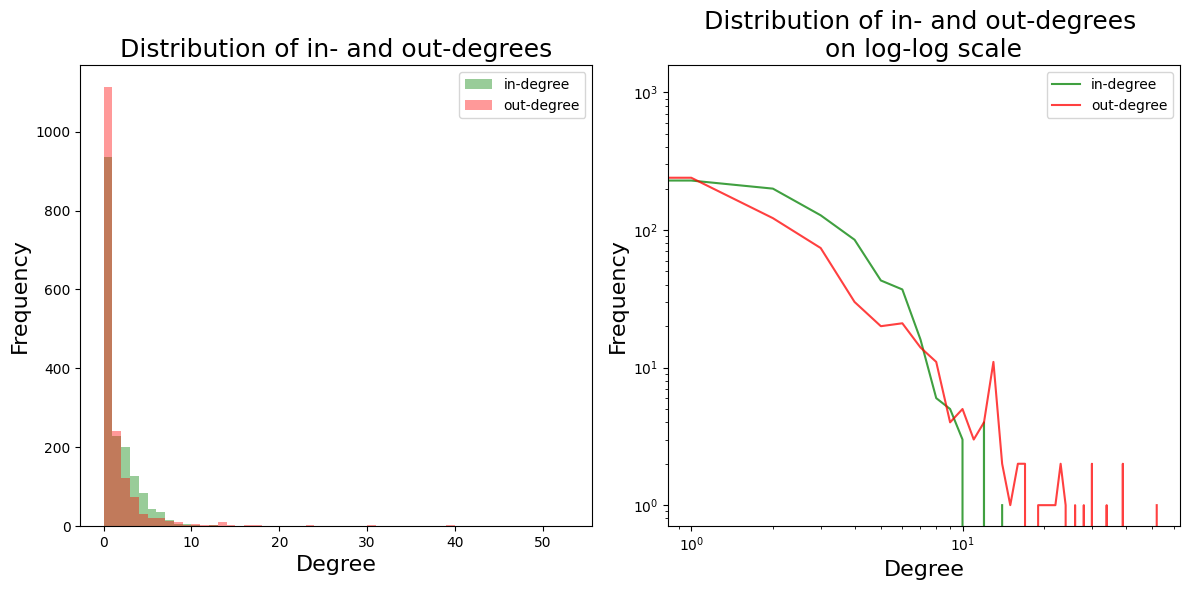

In [12]:
x_in, y_in, degree_i, v_i = create_histogram(G, 'in')
x_out, y_out,degree_o, v_o = create_histogram(G, 'out')
plt.rcParams["figure.figsize"] = (12,6)
plt.subplot(1, 2, 1)
plt.hist(degree_i, bins = v_i, label='in-degree', alpha = 0.4, color = "green")
plt.hist(degree_o, bins = v_o, label='out-degree', alpha = 0.4, color = "red")
plt.xlabel('Degree', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(loc="upper right")
plt.title("Distribution of in- and out-degrees", fontsize = 18)

plt.subplot(1, 2, 2) 
# plt.figure(figsize=(8, 5))
plt.loglog(x_in, y_in, label='in-degree', alpha = 0.75, color = "green")
plt.loglog(x_out, y_out, label='out-degree', alpha = 0.75, color = "red")
plt.xlabel('Degree', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(loc="upper right")
plt.title("Distribution of in- and out-degrees \non log-log scale", fontsize = 18)
plt.tight_layout()
plt.show()

**Distribution plots of degree.** Left barplot shows the distribution of in- and out-degrees. Y-axis shows the frequency of degrees. Right plot shows the distribution of in- and out-degrees on a log-log scale. Y-axis shows the frequency of degrees. Red color shows out-degree and green color shows in-degree. Dark coloring represents overlapping of the distributions.

### Distribution of pre-requisites versus in-degrees

Another interesting thing to look at is the distribution of in-degrees against the attribute `No. of prerequisites`. 

In [13]:
# Collect pre-requisite values
pre_reqs = []
for course in all_courses:
    try:
        info_dict = G.nodes()[str(course)]
        pre_reqs.append(info_dict['No. pre-requisites'])
    except KeyError as e:
        # pass_ = e
        pre_reqs.append(0)

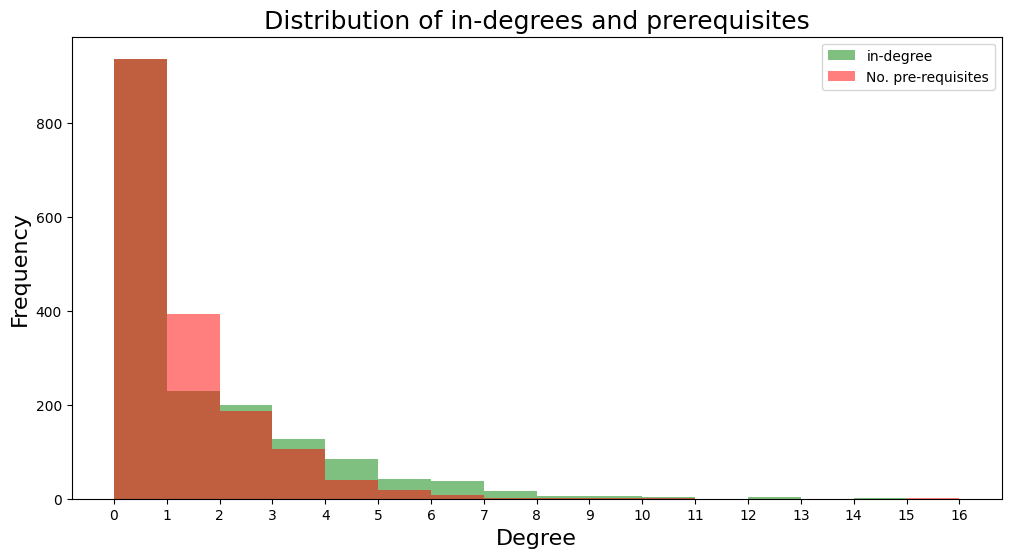

In [14]:
plt.rcParams["figure.figsize"] = (12,6)
min_ylim, max_ylim = plt.ylim()
plt.hist(degree_i, bins = v_i, label='in-degree', alpha = 0.5, color = "green")
plt.hist(pre_reqs, bins=16, label = "No. pre-requisites", alpha=0.5, color='red')
plt.xlabel('Degree', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(loc="upper right")
plt.title("Distribution of in-degrees and prerequisites", fontsize = 18)
plt.xticks(np.arange(0, max(pre_reqs)+1, step=1))
plt.savefig('Pictures/pre_reqs.png',bbox_inches='tight')  
plt.show() 
plt.close()

**Histogram for prerequisites and in-degrees.** The histogram shows the distribution of number of prerequisites for the courses at DTU versus in-degrees. Green color shows in-degree and red color shows number of prerequisites. Dark coloring represents overlap between the left-skewed distributions. 

In the plot above showing the distribution of in-degrees and number of actual prerequisites it is seen that the in-degrees (green) in general have a higher frequency as the degree increases compared to the number of actual prerequisites. From this plot the misleading distribution of the in-degrees compared to the actual needed prerequisites are visualized. This plot thus visualizes that the in-degrees cannot be interpreted exactly as the number of actual needed prerequisites, but as a way to connect all possible courses.

### Centrality measures

Now we have the network consisiting of 1694 nodes and 2088 links. There is different ways of calculating the centrality. Below we investigate the different measures: degree, betweenness, closeness and eigenvector.

**Degree** is the measure of the importance of any node in the network defined by amount of degrees. The node with highest degree is more important and have high impact over the rest of the nodes.

In [15]:
# In-degree
in_central = nx.in_degree_centrality(G)
in_central = dict(sorted(in_central.items(), key=lambda item: item[1], reverse=True))
print("Course with highest importance regarding amount of in-degrees:", list(in_central.keys())[0])

# Out-degree
out_central = nx.out_degree_centrality(G)
out_central = dict(sorted(out_central.items(), key=lambda item: item[1], reverse=True))
print("Course with highest importance regarding amount of out-degrees:", list(out_central.keys())[0])

Course with highest importance regarding amount of in-degrees: 62573
Course with highest importance regarding amount of out-degrees: 02631


**Betweeness** is the measure defined when looking at the shortest paths between the nodes and observe which one is visited most times. The node which is visited most while traversing the shortest paths in the network have a higher centrality.

In [16]:
betweeness = nx.betweenness_centrality(G)
betweeness = dict(sorted(betweeness.items(), key=lambda item: item[1], reverse=True))

print("Course with highest importance regarding betweeness:", list(betweeness.keys())[0])

Course with highest importance regarding betweeness: 01035


**Closeness** is the measure of the importance of any node in the network by taking the average distance of a node from all the other nodes. Nodes with high closeness value will have the shortest path to other nodes. So the node with highest important is the one with highest closeness value.

In [17]:
closeness = nx.closeness_centrality(G)
closeness = dict(sorted(closeness.items(), key=lambda item: item[1], reverse=True))

print("Course with highest importance regarding closeness:", list(closeness.keys())[0])

Course with highest importance regarding closeness: 02830


**Eigenvector** is the measure assigning a value to a node with respect to the other nodes it is connected to. The node connected to another node with better importance will get a better centrality value. Hence a high eigenvector value means that this certain node is connected to other nodes with high scores as well.

In [18]:
eigenvector = nx.eigenvector_centrality(G)
eigenvector = dict(sorted(eigenvector.items(), key=lambda item: item[1], reverse=True))

print("Course with highest importance regarding eigenvector:", list(eigenvector.keys())[0])

Course with highest importance regarding eigenvector: 22123


*Full course names for course numbers mentioned above.*
62573: Programming intelligent vehicles and Mobile Applications
02631: Introduction to programming and data processing
01035: Advanced Engineering Mathematics 2
02830 Advanced Project in Digital Media Engineering
22123 Computational Precision Medicine

### Actual prerequisites

The networks in-degrees are a bit misleading according to what they actually mean. The way the network is built up now, the in-degrees for a certain node tell us which courses that are prerequisites for this node, however it does not imply how many of these prerequisites that are necessary to have before attending the course of the node. The attribute 'No. pre-requisites' gives us this exact information of how many courses that are actually necessary to attend before this course. In the following we will find the course that requires the highest amount of prerequisites and compare to the in-degree highest importance regarding amount of in-degrees.

In [19]:
# Highest in-degree according to attribute 'No. pre-requisites'
no_preq = {}
for course in all_courses:
    try:
        no_pr = G.nodes()[course]['No. pre-requisites']
        no_preq[course] = no_pr
    except:
        pass

high_preq = max(no_preq, key=no_preq.get)
high_in_deg = list(in_central.keys())[0]

print('The course with the highest amount of needed prerequisites is course {} with {} needed prerequisite(s) and \n{} possible courses as prerequisite(s).'.format(high_preq, str(no_preq[high_preq]), str(G.in_degree[high_preq])))
print('The in-degree with the highest importance regarding amount of in-degrees is course {} with {} needed prerequisite(s) \ncompared to the {} courses that are presented as prerequisite(s).'.format(high_in_deg, str(no_preq[high_in_deg]), str(G.in_degree[high_in_deg])))

The course with the highest amount of needed prerequisites is course 41936 with 16 needed prerequisite(s) and 
10 possible courses as prerequisite(s).
The in-degree with the highest importance regarding amount of in-degrees is course 62573 with 1 needed prerequisite(s) 
compared to the 15 courses that are presented as prerequisite(s).


We observe that the course 62573 Programming intelligent vehicles and Mobile Applications that we found as the course with highest importance regarding in-degrees in reality only have 1 needed prerequisite even though 15 coures are presented as prerequisites. In order to take this course one should only have taken one other course before. However for course 41936 Advanced Building Design it is actually recommended for one to have participated 16 courses before taking this course. Though, our network has only recognized 10 in-degrees for this course, which is due to the fact that some of the prerequisite courses are not actually a part of our network. The network only consists of courses offered at school year 2022/2023, which excludes some of the courses that were offered before.

## Visualizing network - Force Atlas

Now that we have our network with nodes and links we wish to visualize it using the Force Atlas algorithm. Below we go from a directed graph to an undirected graph `U`. From undirected graph we remove isolated nodes and keep only the largest component `U0`. 
The coloring is based in the study program and node sizes are based on amount of degrees.

In [58]:
# Graph G to undirected
U = G.to_undirected()

# Create network being the largest component
U0 = U.copy()
U0.remove_nodes_from(list(nx.isolates(U0)))
components = sorted(nx.connected_components(U0), key=len, reverse=True)
U0 = U0.subgraph(components[0])

In [60]:
# Create empty list for node colors and programs
node_color_u, node_color_u0 = [], []
dtu_courses_bsc_u, dtu_courses_bsc_u0 = [], []
dtu_courses_msc_u, dtu_courses_msc_u0 = [], []
dtu_courses_phd_u, dtu_courses_phd_u0 = [], []
dtu_courses_diplom_u, dtu_courses_diplom_u0 = [], []
dtu_courses_part_msc_u, dtu_courses_part_msc_u0 = [], []
dtu_courses_part_diplom_u, dtu_courses_part_diplom_u0 = [], []

# Nodes in U0
nodes_u0 = list(U0.nodes())

# Create color dict
program_col_dict = {}

# For each node in the graph
for node in U.nodes(data=True):
    node_name = node[0]

    # Node attribute is bachelor
    if 'DTU_BSC' in node[1]['Course type']:
        node_color_u.append('black')
        dtu_courses_bsc_u.append(node[0])
        program_col_dict['DTU_BSC'] = 'black'
        if node_name in U0:
            node_color_u0.append('black')
            dtu_courses_bsc_u0.append(node[0])

    # Node attribute is master
    elif 'DTU_MSC' in node[1]['Course type']:
        node_color_u.append('yellow') 
        dtu_courses_msc_u.append(node[0])
        program_col_dict['DTU_MSC'] = 'yellow'
        if node_name in U0:
            node_color_u0.append('yellow')
            dtu_courses_msc_u0.append(node[0])
    
    # Node attribute is phD
    elif 'DTU_PHD' in node[1]['Course type']:
        node_color_u.append('blue') 
        dtu_courses_phd_u.append(node[0])
        program_col_dict['DTU_PHD'] = 'blue' 
        if node_name in U0:
            node_color_u0.append('blue')
            dtu_courses_phd_u0.append(node[0])
    
    # Node attribute is dimploma
    elif 'DTU_DIPLOM' in node[1]['Course type']:
        node_color_u.append('red') 
        dtu_courses_diplom_u.append(node[0])
        program_col_dict['DTU_DIPLOM'] = 'red'
        if node_name in U0:
            node_color_u0.append('red')
            dtu_courses_diplom_u0.append(node[0])
        
    # Node attribute is parttime master
    elif 'DTU_PARTTIME_MASTER' in node[1]['Course type']:
        node_color_u.append('green') 
        dtu_courses_part_msc_u.append(node[0])
        program_col_dict['DTU_PARTTIME_MASTER'] = 'green'
        if node_name in U0:
            node_color_u0.append('green')
            dtu_courses_part_msc_u0.append(node[0]) 
        
    # Node attribute is parttime diploma
    elif 'DTU_PARTTIME_DIPLOM' in node[1]['Course type']:
        node_color_u.append('purple') 
        dtu_courses_part_diplom_u.append(node[0])
        program_col_dict['DTU_PARTTIME_DIPLOM'] = 'purple'
        if node_name in U0:
            node_color_u0.append('purple')
            dtu_courses_part_diplom_u0.append(node[0])

In [76]:
list_all_u_programs = [dtu_courses_bsc_u, dtu_courses_msc_u, dtu_courses_phd_u, dtu_courses_diplom_u, dtu_courses_part_msc_u, dtu_courses_part_diplom_u]
list_all_u0_programs = [dtu_courses_bsc_u0, dtu_courses_msc_u0, dtu_courses_phd_u0, dtu_courses_diplom_u0, dtu_courses_part_msc_u0, dtu_courses_part_diplom_u0]
program_names = list(program_col_dict.keys())

print("Amount of courses based on study program in graph U and U0:")
for i in range(0, 6):
    print("({}) Original graph: {} \tLargest component: {}".format(program_names[i], len(list_all_u_programs[i]), len(list_all_u0_programs[i])))

Amount of courses based on study program in graph U and U0:
(DTU_BSC) Original graph: 349 	Largest component: 258
(DTU_MSC) Original graph: 728 	Largest component: 426
(DTU_PHD) Original graph: 146 	Largest component: 22
(DTU_DIPLOM) Original graph: 318 	Largest component: 188
(DTU_PARTTIME_MASTER) Original graph: 62 	Largest component: 0
(DTU_PARTTIME_DIPLOM) Original graph: 91 	Largest component: 0


We see that the largest component doesn't have courses with study program being parttime diploma or parttime master. Furthermore there is a large reduction in amount of PhD. and diploma courses.

100%|██████████| 2000/2000 [00:39<00:00, 50.40it/s]
BarnesHut Approximation  took  17.35  seconds
Repulsion forces  took  20.03  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.08  seconds
AdjustSpeedAndApplyForces step  took  0.99  seconds
100%|██████████| 2000/2000 [00:12<00:00, 155.82it/s]
BarnesHut Approximation  took  5.57  seconds
Repulsion forces  took  6.04  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.08  seconds
AdjustSpeedAndApplyForces step  took  0.52  seconds


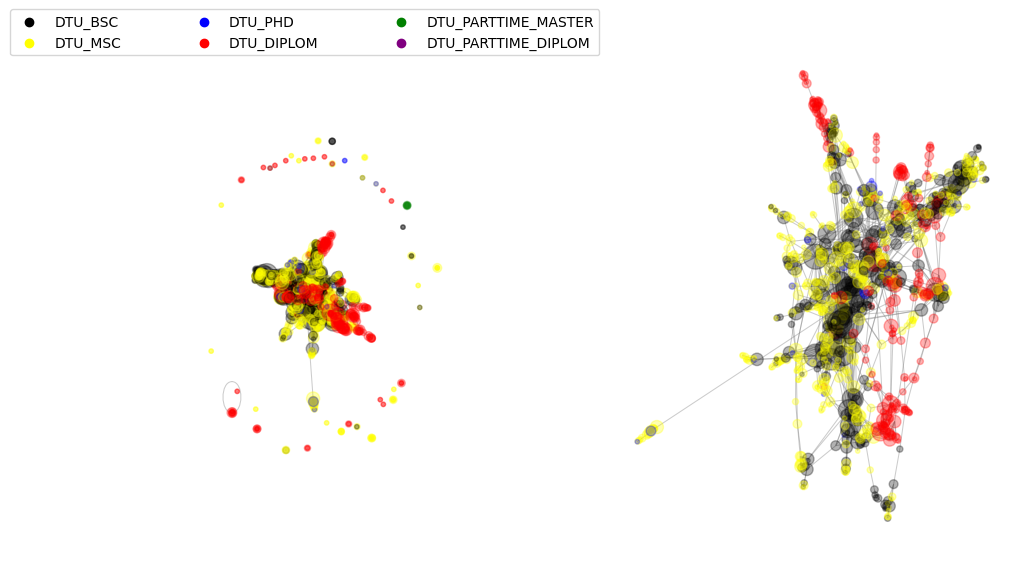

In [64]:
# Graph with all nodes
plt.rcParams["figure.figsize"] = (12, 7)
plt.subplot(1, 2, 1)
fa(U, node_color_u)

# Make empty plot with correct color and label for each program
for k in list(program_col_dict.keys()):
    plt.scatter([],[], c = program_col_dict[k], label = k)
plt.legend(bbox_to_anchor=(0, 1.1, 1, 0.2), loc="lower left", mode="expand", borderaxespad=-6, ncol=3)

# Graph being the largest component
plt.subplot(1, 2, 2)
fa(U0, node_color_u0)

plt.show()

**Force Atlas plots**. Left plot shows the entire network with all courses. Right plot shows the largest component of the network. Coloring of both plots is based on the program attribute: black is bachelor, yellow is master, blue is PhD, red is diploma, green is parttime master and purple is parttime diploma. it is generated using the Force Atlas algorithm.

### Force Atlas by departments

Before visualization we are going to check if all departments in the largest component has courses related. If not then they are removed from further analysis.

In [23]:
# Now see the distribution of nodes not in largest component
# Delete values for now
for dep in dep_dict:
    dep_dict[dep] = []

# Loop over courses in the oi list
for course in list(U0.nodes()):
    try:
        department = G.nodes()[course]['Department']

        # Add if mentioned in community
        dep_dict[department].append(1)
    except KeyError as e:
        pass_ = e

# Sum values in list
print("No courses is related to the department(s):")
for key, vals in dep_dict.copy().items():
    dep_dict[key] = sum(vals)
    if sum(vals) == 0 :
        print(key)
        # Delete key/department
        del dtu_department[key]

No courses is related to the department(s):
29 DTU Biosustain
56 DTU Nanolab


In [24]:
department_colors = {'01 Department of Applied Mathematics and Computer Science': "red",
                     '10 Department of Physics': "orange",
                     '12 Department of Environmental Engineering': "green",
                     '22 Department of Health Technology': "blue",
                     '23 National Food Institute': "darkolivegreen",
                     '25 National Institute of Aquatic Resources': "lightblue",
                     '26 Department of Chemistry': "silver",
                     '27 Department of Biotechnology and Biomedicine': "lavender",
                     '28 Department of Chemical Engineering': "darkorchid",
                    #  '29 DTU Biosustain': "goldenrod",
                     '30 National Space Institute': "peru",
                     '34 Department of Photonics Engineering': "violet",
                     '41 Department of Mechanical Engineering': "purple",
                     '42 Department of Technology, Management and Economics ': "saddlebrown",
                     '46 Department of Wind Energy': "wheat",
                     '47 Department of Energy Conversion and Storage': "black",
                    #  '56 DTU Nanolab': "cornflowerblue",
                     '88 Other courses': "darkkhaki",
                     '62 Department of Engineering Technology and Didactics': "coral"}

In [25]:
# Create empty list for node colors and departments
node_col_dep = []

# For each node in the graph
for node in U0.nodes(data=True):
    department = node[1]['Department']
    node_col_dep.append(department_colors[department])

100%|██████████| 2000/2000 [00:13<00:00, 152.75it/s]
BarnesHut Approximation  took  5.72  seconds
Repulsion forces  took  6.06  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.52  seconds


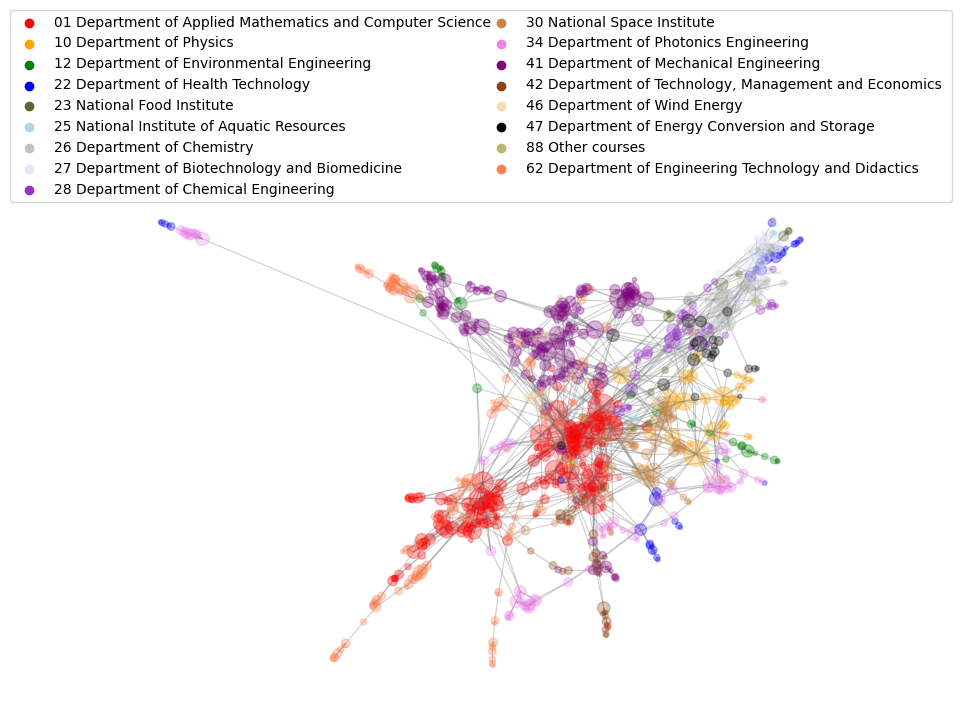

In [26]:
# Graph colored by departments
plt.rcParams["figure.figsize"] = (10,7)
fa(U0, node_col_dep)

# Make empty plot with correct color and label for each department
for k in list(department_colors.keys()):
    plt.scatter([],[], c=department_colors[k], label=k)

plt.legend(bbox_to_anchor=(0, 1.1, 1, 0.2), loc="lower left", mode="expand", borderaxespad=-6, ncol=2)
plt.show()

**Force Atlas plot.** Plot shows the largest component of the graph colored by departments. It is generated using the Force Atlas algorithm.

## Sentiment analysis

In the following we are going to look into the distribution of sentiment scores for each course. First we are going to view the distribution of the scoring for bachelor versus master programme. Afterwards we do the same for four of the most prevalent amount of ECTS points given as an attribute.  
The entire analysis will be based on the original graph G.

### BSC versus MSC

Comparing sentiment values between courses that are registered as a bachelor or master course. Due to different amount of courses with either bachelor or master as the 'Program' attribute, data is weighted.

In [27]:
# Split dictionary into 2 by value for key "Course type"
sentiment_bsc = []
sentiment_msc = []
happiness_bsc = []
happiness_msc = []

for course in all_courses:
    info_dict = G.nodes()[str(course)]
    try:
        # Is is bachelor?
        if info_dict['Course type'] == "DTU_BSC":
            # Get sentiment values
            sentiment_bsc.append(info_dict['Sentiment'])
            happiness_bsc.append(info_dict['Evaluation happiness'])

        # Is it master
        elif info_dict['Course type'] == "DTU_MSC":
            # Get sentiment values
            sentiment_msc.append(info_dict['Sentiment'])
            happiness_msc.append(info_dict['Evaluation happiness'])
    except KeyError as e:
        pass_ = e

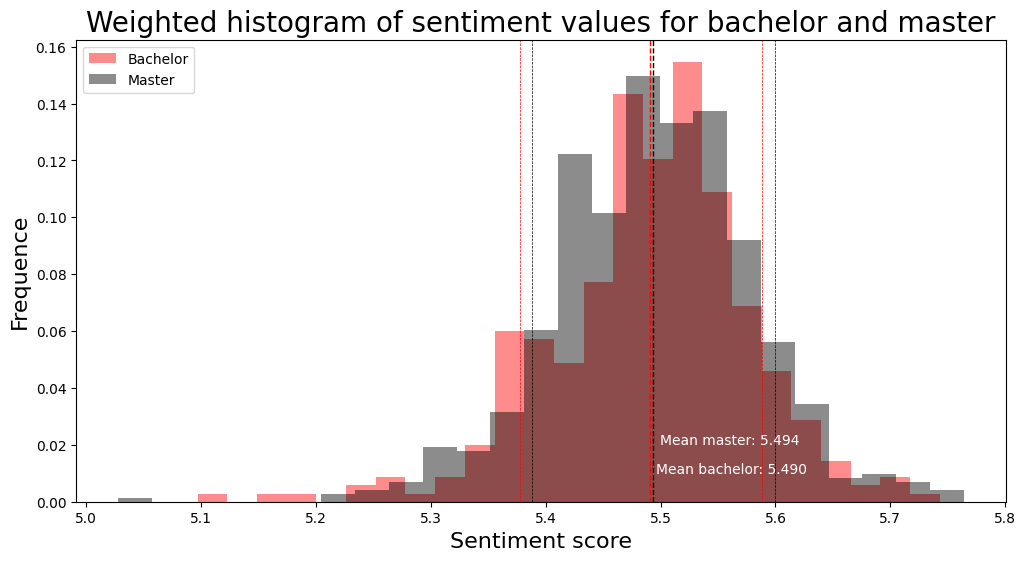

In [28]:
# Weighted/normalized histogram
weights_bsc = np.ones_like(sentiment_bsc)/float(len(sentiment_bsc))
weights_msc = np.ones_like(sentiment_msc)/float(len(sentiment_msc))

# Percentiles
perc10_bsc = np.percentile(sentiment_bsc, 10)
perc90_bsc = np.percentile(sentiment_bsc, 90)
# print("Statistics of the sentiment{}:\nMean Value: {:.4f}\n10th Percentile Value: {:.4}\n90th Percentile Value: {:.4}".format(comment, mean_snt, perc10_snt, perc90_snt))
perc10_msc = np.percentile(sentiment_msc, 10)
perc90_msc = np.percentile(sentiment_msc, 90)
# print("Statistics of the sentiment{}:\nMean Value: {:.4f}\n10th Percentile Value: {:.4}\n90th Percentile Value: {:.4}".format(comment,mean_snt, perc10_snt, perc90_snt))

# Plotting two histograms on the same axis
plt.rcParams["figure.figsize"] = (12,6)
min_ylim, max_ylim = plt.ylim()
plt.hist(sentiment_bsc, bins=25, alpha=0.45, color='red', weights = weights_bsc, label = "BSc")
plt.hist(sentiment_msc, bins=25, alpha=0.45, color='black', weights = weights_msc, label = "MSc")
plt.legend(["Bachelor", "Master"], loc='upper left')
plt.axvline(perc10_bsc, color='red', linestyle='dashed', linewidth=0.5)
plt.axvline(perc90_bsc, color='red', linestyle='dashed', linewidth=0.5)
plt.axvline(perc10_msc, color='black', linestyle='dashed', linewidth=0.5)
plt.axvline(perc90_msc, color='black', linestyle='dashed', linewidth=0.5)
plt.axvline(np.mean(sentiment_bsc), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(sentiment_msc), color='black', linestyle='dashed', linewidth=1)
plt.text(np.mean(sentiment_bsc)*1.001, 0.01, 'Mean bachelor: {:.3f}'.format(np.mean(sentiment_bsc)), color="white")
plt.text(np.mean(sentiment_msc)*1.001, 0.02, 'Mean master: {:.3f}'.format(np.mean(sentiment_msc)), color="white")
plt.title("Weighted histogram of sentiment values for bachelor and master", fontsize = 20)
plt.xlabel("Sentiment score", fontsize=16)
plt.ylabel("Frequence", fontsize=16)
plt.savefig('Pictures/programbarplot.png',bbox_inches='tight')  
plt.show() 
plt.close()

**Weighted histogram of sentiment values for courses with bachelor and master program attribute.** Red bins represent bachelor, while black bins represent master program. Dark coloring represents overlapping of the distributions. Mean values for each histogram is shown in plot. There is a slight difference in the mean values. The red and black vertical lines represent the 90th percentiles for bachelor and master respectively. We see the percentiles for bachelor is shifted more to the left than for master. 

We can also take a look at the distribution of evaluation happiness scores for courses parted in master and bachelor program.

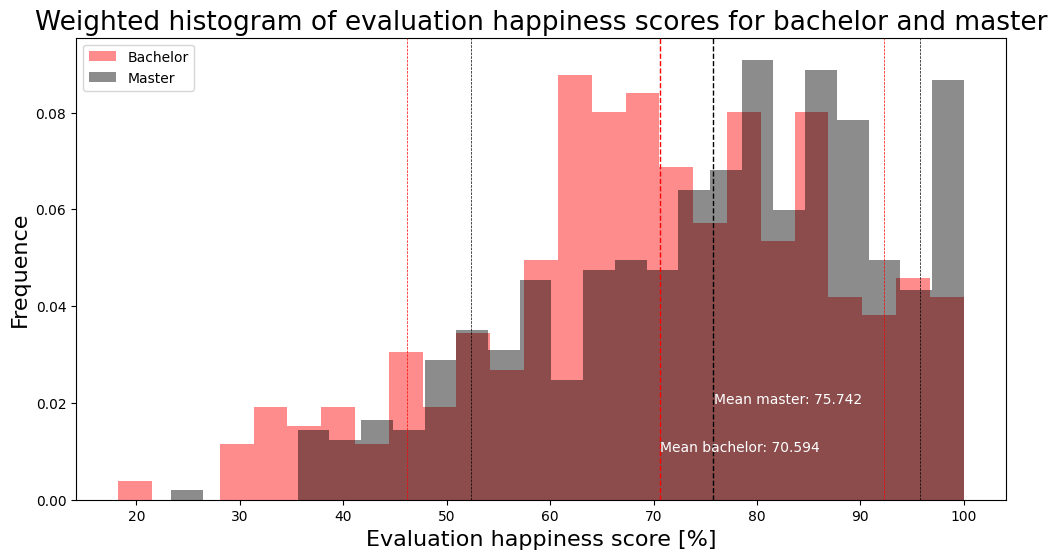

In [29]:
# Weighted/normalized histogram
weights_bsc = np.ones_like(happiness_bsc)/float(len(happiness_bsc))
weights_msc = np.ones_like(happiness_msc)/float(len(happiness_msc))

# Percentiles
perc10_bsc = np.percentile(happiness_bsc, 10)
perc90_bsc = np.percentile(happiness_bsc, 90)
# print("Statistics of the sentiment{}:\nMean Value: {:.4f}\n10th Percentile Value: {:.4}\n90th Percentile Value: {:.4}".format(comment, mean_snt, perc10_snt, perc90_snt))
perc10_msc = np.percentile(happiness_msc, 10)
perc90_msc = np.percentile(happiness_msc, 90)
# print("Statistics of the sentiment{}:\nMean Value: {:.4f}\n10th Percentile Value: {:.4}\n90th Percentile Value: {:.4}".format(comment,mean_snt, perc10_snt, perc90_snt))

# Plotting two histograms on the same axis
plt.rcParams["figure.figsize"] = (12,6)
min_ylim, max_ylim = plt.ylim()
plt.hist(happiness_bsc, bins=25, alpha=0.45, color='red', weights = weights_bsc, label = "BSc")
plt.hist(happiness_msc, bins=25, alpha=0.45, color='black', weights = weights_msc, label = "MSc")
plt.legend(["Bachelor", "Master"])
plt.axvline(perc10_bsc, color='r', linestyle='dashed', linewidth=0.5)
plt.axvline(perc90_bsc, color='r', linestyle='dashed', linewidth=0.5)
plt.axvline(perc10_msc, color='black', linestyle='dashed', linewidth=0.5)
plt.axvline(perc90_msc, color='black', linestyle='dashed', linewidth=0.5)
plt.axvline(np.mean(happiness_bsc), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(happiness_msc), color='black', linestyle='dashed', linewidth=1)
plt.text(np.mean(happiness_bsc)*1.001, 0.01, 'Mean bachelor: {:.3f}'.format(np.mean(happiness_bsc)), color="white")
plt.text(np.mean(happiness_msc)*1.001, 0.02, 'Mean master: {:.3f}'.format(np.mean(happiness_msc)), color="white")
plt.title("Weighted histogram of evaluation happiness scores for bachelor and master", fontsize = 19)
plt.xlabel("Evaluation happiness score [%]", fontsize=16)
plt.ylabel("Frequence", fontsize=16)
plt.savefig('Pictures/evalhappinessbarplot.png',bbox_inches='tight')  
plt.show() 
plt.close()

**Weighted histogram of happiness evaluation scores for bachelor and master program attribute.** Red bins represents bachelor, while black bins represent master program. Dark coloring represents overlapping of the distributions. Mean values for each histogram is shown in plot. The red and black vertical lines represent the 90th percentiles for bachelor and master respectively. We see the percentiles and mean value for bachelor is shifted more to the left than for master.

We do not see a big difference in the weighted histogram for the sentiment scores between bachelor and master program. But when looking at the evaluation happiness scores there is a larger deviation between the programs, were the bachelor courses are being evaluated less positively than master courses.
Below a two sample t-test is performed to test if the difference is significant.

In [30]:
# Perform the two sample t-test with equal variances
sentiment_t_test = stats.ttest_ind(a=sentiment_bsc, b=sentiment_msc, equal_var=True)
happiness_t_test = stats.ttest_ind(a=happiness_bsc, b=happiness_msc, equal_var=True)
print("T-test for sentiment scores parted by program (p-value):", sentiment_t_test.pvalue)
print("T-test for evaluation happiness scores parted by program (p-value):", happiness_t_test.pvalue)

T-test for sentiment scores parted by program (p-value): 0.5852874355162119
T-test for evaluation happiness scores parted by program (p-value): 4.8522886802838316e-05


**Hypothesis 1**
H0: µ1 = µ2 (mean of sentiment scores for bachelor equals the mean of sentiment scores for master)
HA: µ1 ≠ µ2 (mean of sentiment scores for bachelor is different from the mean of sentiment scores for master)

We found the p-value of sentiment scores to be 0.5853 which is greater than α = 0.05, so we cannot reject the null hypothesis of the t-test. 

**Hypothesis 2**
H0: µ1 = µ2 (mean of evaluation happiness scores for bachelor equals the mean of evaluation happiness scores for master)
HA: µ1 ≠ µ2 (mean of evaluation happiness scores for bachelor is different from the mean of evaluation happiness scores for master)

We found the p-value of evaluation happiness scores to be very small (4.8522886802838316e-05) which is less than α = 0.05, so we can reject the null hypothesis of the t-test. There is a statistical difference between bachelor and master courses regarding happiness evalution scores. 

### Distribution of ECTS points

We are now going to look at the distribution for sentiment scores parted by the attribute `Points(ECTS)`. There is 18 different values of ECTS points for DTU courses. So in the following we are only looking into the 4 most occuring values.

In [31]:
P = G.copy()
points = []
points_dict = {0.0: 0, 20.0: 0, 17.5: 0, 5.0: 0, 10.0: 0, 7.5: 0, 2.5: 0, 8.0: 0, 6.0: 0,
               12.5: 0, 15.0: 0, 4.0: 0, 3.5: 0, 3.0: 0, 1.5: 0, 2.0: 0, 4.5: 0, 1.0: 0}
for course in all_courses:
    try:
        if P.nodes()[course]['Points(ECTS)'] not in points:
            points.append(P.nodes()[course]['Points(ECTS)'])
        points_dict[P.nodes()[course]['Points(ECTS)']] += 1
    except KeyError as e:
        # print("Could not find points for", course)
        pass_ = e

print("4 ECTS values occuring most often and their occurence:\n", dict(sorted(points_dict.items(), key=lambda item: item[1], reverse=True)[0:4]), sep = "")

4 ECTS values occuring most often and their occurence:
{5.0: 1251, 10.0: 267, 7.5: 53, 2.5: 46}


In [32]:
# Split dictionary into 2 by value for key "Course type"
sentiment_2_5 = []
sentiment_5 = []
sentiment_7_5 = []
sentiment_10 = []

happiness_2_5 = []
happiness_5 = []
happiness_7_5 = []
happiness_10 = []

for course in all_courses:
    try:
        info_dict = P.nodes()[str(course)]
        if info_dict['Points(ECTS)'] == 2.5:
            sentiment_2_5.append(info_dict['Sentiment'])
            happiness_2_5.append(info_dict['Evaluation happiness'])

        elif info_dict['Points(ECTS)'] == 5:
            sentiment_5.append(info_dict['Sentiment'])
            happiness_5.append(info_dict['Evaluation happiness'])
            
        elif info_dict['Points(ECTS)'] == 7.5:
            sentiment_7_5.append(info_dict['Sentiment'])
            happiness_7_5.append(info_dict['Evaluation happiness'])
            
        elif info_dict['Points(ECTS)'] == 10:
            sentiment_10.append(info_dict['Sentiment'])
            happiness_10.append(info_dict['Evaluation happiness'])

    except KeyError as e:
        pass_ = e

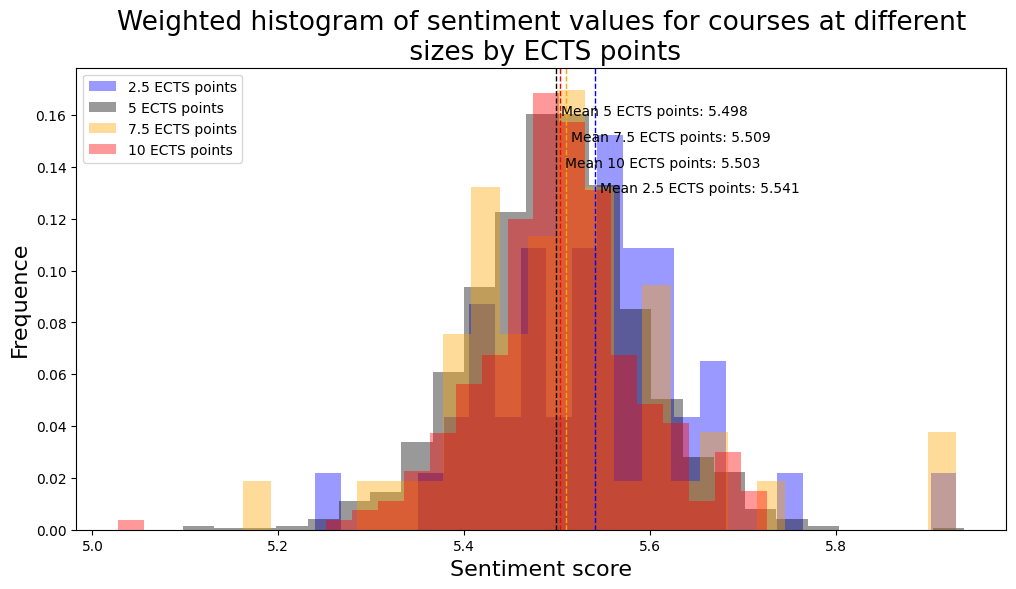

In [33]:
sentiment_2_5 = [x for x in sentiment_2_5 if x is not None]
sentiment_5 = [x for x in sentiment_5 if x is not None]
sentiment_7_5 = [x for x in sentiment_7_5 if x is not None]
sentiment_10 = [x for x in sentiment_10 if x is not None]

# Weighted/normalized histogram
weights_2_5 = np.ones_like(sentiment_2_5)/float(len(sentiment_2_5))
weights_5 = np.ones_like(sentiment_5)/float(len(sentiment_5))
weights_7_5 = np.ones_like(sentiment_7_5)/float(len(sentiment_7_5))
weights_10 = np.ones_like(sentiment_10)/float(len(sentiment_10))

# Plotting two histograms on the same axis
plt.rcParams["figure.figsize"] = (12,6)
min_ylim, max_ylim = plt.ylim()
plt.hist(sentiment_2_5, bins=25, alpha=0.4, color='blue', weights = weights_2_5, label = "2.5 points")
plt.hist(sentiment_5, bins=25, alpha=0.4, color='black', weights = weights_5, label = "5 points")
plt.hist(sentiment_7_5, bins=25, alpha=0.4, color='orange', weights = weights_7_5, label = "7.5 points")
plt.hist(sentiment_10, bins=25, alpha=0.4, color='red', weights = weights_10, label = "10 points")
plt.axvline(np.mean(sentiment_2_5), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(sentiment_5), color='black', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(sentiment_7_5), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(sentiment_10), color='red', linestyle='dashed', linewidth=1)
plt.text(np.mean(sentiment_2_5)*1.001, 0.13, 'Mean 2.5 ECTS points: {:.3f}'.format(np.mean(sentiment_2_5)))
plt.text(np.mean(sentiment_5)*1.001, 0.16, 'Mean 5 ECTS points: {:.3f}'.format(np.mean(sentiment_5)))
plt.text(np.mean(sentiment_7_5)*1.001, 0.15, 'Mean 7.5 ECTS points: {:.3f}'.format(np.mean(sentiment_7_5)))
plt.text(np.mean(sentiment_10)*1.001, 0.14, 'Mean 10 ECTS points: {:.3f}'.format(np.mean(sentiment_10)))
plt.title("Weighted histogram of sentiment values for courses at different\n sizes by ECTS points", fontsize = 19)
plt.legend(["2.5 ECTS points", "5 ECTS points", "7.5 ECTS points", "10 ECTS points"], loc='upper left')
plt.xlabel("Sentiment score", fontsize=16)
plt.ylabel("Frequence", fontsize=16)
plt.savefig('Pictures/ECTSbarplot.png',bbox_inches='tight')  
plt.show() 
plt.close()

**Weighted histogram of sentiment values for courses by ECTS points.** The histogram shows the 4 most occuring ECTS values as attribute for all courses. Blue bins represent 2.5 points, yellow bins represent 5 points, black bins represent 7.5 points and red bins represent 10 points. Dark coloring represents overlapping of the distributions. Mean values are shown as vertical striped lines. 2.5 points has the highest mean value of 5.541.

We can also take a look at the distribution of evaluation happiness scores for courses parted by ECTS points.

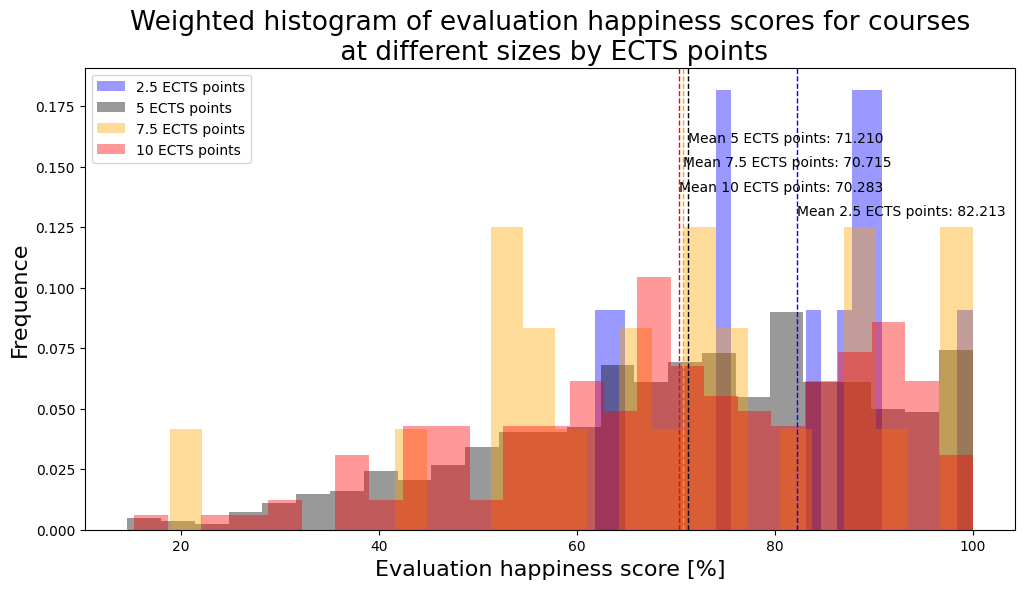

In [34]:
happiness_2_5 = [x for x in happiness_2_5 if x is not None]
happiness_5 = [x for x in happiness_5 if x is not None]
happiness_7_5 = [x for x in happiness_7_5 if x is not None]
happiness_10 = [x for x in happiness_10 if x is not None]

# Weighted/normalized histogram
weights_2_5 = np.ones_like(happiness_2_5)/float(len(happiness_2_5))
weights_5 = np.ones_like(happiness_5)/float(len(happiness_5))
weights_7_5 = np.ones_like(happiness_7_5)/float(len(happiness_7_5))
weights_10 = np.ones_like(happiness_10)/float(len(happiness_10))

# Plotting two histograms on the same axis
plt.rcParams["figure.figsize"] = (12,6)
min_ylim, max_ylim = plt.ylim()
plt.hist(happiness_2_5, bins=25, alpha=0.4, color='blue', weights = weights_2_5, label = "2.5 points")
plt.hist(happiness_5, bins=25, alpha=0.4, color='black', weights = weights_5, label = "5 points")
plt.hist(happiness_7_5, bins=25, alpha=0.4, color='orange', weights = weights_7_5, label = "7.5 points")
plt.hist(happiness_10, bins=25, alpha=0.4, color='red', weights = weights_10, label = "10 points")
plt.axvline(np.mean(happiness_2_5), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(happiness_5), color='black', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(happiness_7_5), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(happiness_10), color='red', linestyle='dashed', linewidth=1)
plt.text(np.mean(happiness_2_5)*1.001, 0.13, 'Mean 2.5 ECTS points: {:.3f}'.format(np.mean(happiness_2_5)))
plt.text(np.mean(happiness_5)*1.001, 0.16, 'Mean 5 ECTS points: {:.3f}'.format(np.mean(happiness_5)))
plt.text(np.mean(happiness_7_5)*1.001, 0.15, 'Mean 7.5 ECTS points: {:.3f}'.format(np.mean(happiness_7_5)))
plt.text(np.mean(happiness_10)*1.001, 0.14, 'Mean 10 ECTS points: {:.3f}'.format(np.mean(happiness_10)))
plt.title("Weighted histogram of evaluation happiness scores for courses\n at different sizes by ECTS points", fontsize = 19)
plt.legend(["2.5 ECTS points", "5 ECTS points", "7.5 ECTS points", "10 ECTS points"], loc='upper left')
plt.xlabel("Evaluation happiness score [%]", fontsize=16)
plt.ylabel("Frequence", fontsize=16)
plt.savefig('Pictures/ECTSbarplothappiness.png',bbox_inches='tight')  
plt.show() 
plt.close()

**Weighted histogram of happiness evaluation scores for courses by ECTS points.** The histogram shows the 4 most occuring ECTS values as attribute for all courses. Blue bins represent 2.5 points, yellow bins represent 5 points, black bins represent 7.5 points and red bins represent 10 points. Dark coloring represents overlapping of the distributions. Mean values are shown as vertical striped lines. 2.5 points has the highest mean value of 82.213 %.

### Conclusional marks on sentiment and evaluation happiness scores

First we looked at the sentiment scores for courses being bachelor or master program. Here we didn't find any significant difference in the distributions, only a slight on when looking at the percentiles. These showed that the sentiment scores are a bit lower for bachelor.  
The distributions for sentiments scores were also investigated for courses by ECTS points. Courses at 2.5 ECTS points is shown to have a higher sentiment scoring than the 3 other ECTS points investigated. Here we only looked at the mean values.

For the same attributes we looked at the distributions for evaluation happiness scores. Using t-test we found a statistical difference between bachelor and master courses based on evaluation happiness scores. Master courses have a evaluation happiness score of more than 5% higher than bachelor courses. This is visual in the mean and 90th percentiles.
For the ECTS points courses at 2.5 ECTS points is having a mean evaluation happiness scoring over 10% higher than the 3 others. From the results it's important to have in mind the varying amount of courses at the different ECTS points.

## Communities

In this part we are going to identify and visualize communities of the departments for all courses. The community detection is found by Louvain-algorithm implementation. 
The community detection is based on the graph U containing the largest component of the graph G.

In [35]:
# First compute the best partition
U1 = U0.copy()
partition = community.best_partition(U1, random_state = seed)
size = float(len(set(partition.values())))
print("Communities:", size)

# Initialize
pos = nx.spring_layout(U1, k=0.15)
com_list = []

for com in set(partition.values()) :
    # col = community_col[com]
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    com_list.append(list_nodes)

    # Add community as attribute to nodes
    for node in list_nodes:
        U0.nodes()[node]['Community'] = com
        U1.nodes()[node]['Community'] = com
        G.nodes()[node]['Community'] = com

Communities: 19.0


In [36]:
# Create empty list for node colors and departments
node_color_com = []
department_palette = list(department_colors.values())
department_palette.append("yellow")
department_palette.append("cornflowerblue")
department_palette.append("goldenrod")

# Create color dict
com_col_dict = {}
# For each node in the graph
for node in U0.nodes(data=True):
    com = node[1]['Community']
    node_color_com.append(department_palette[com])
    com_col_dict['Community {}'.format(com+1)] = department_palette[com]

100%|██████████| 2000/2000 [00:13<00:00, 152.35it/s]
BarnesHut Approximation  took  5.66  seconds
Repulsion forces  took  6.23  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.53  seconds


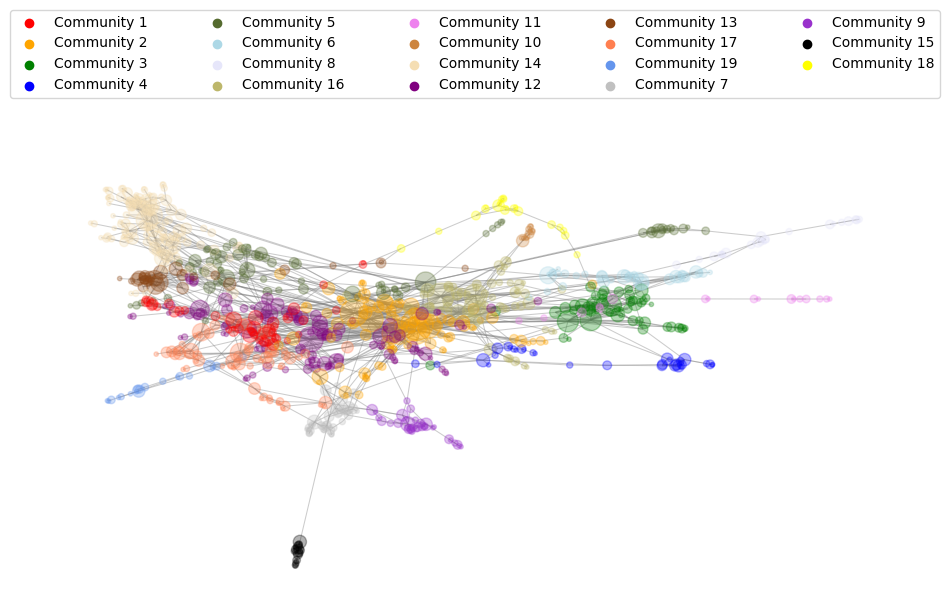

In [37]:
# make empty plot with correct color and label for each community
for k in list(com_col_dict.keys()):
    plt.scatter([],[], c=com_col_dict[k], label=k)
plt.legend(bbox_to_anchor=(0, 1.1, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=5)

# Graph with all nodes
plt.rcParams["figure.figsize"] = (10, 7)
fa(U0, node_color_com, export = "Pictures/communityFA.png")

**Force Atlas plot.** Plot of the 19 communities found from the Louvain community algorithm. Each community is colored with a unique color.

In [38]:
# Modularity
mod = community.modularity(partition, U0)
print("Modularity for department parition:", round(mod, 2))

# Community count and size
print("Number of communities:", int(size))
print("\nSize of communities")
com_count = sorted(Counter(partition.values()).items(), reverse=False)

min_key, min_count = min(com_count, key=itemgetter(1))
max_key, max_count = max(com_count, key=itemgetter(1))
print("Community {} with {} nodes is the smallest.".format(min_key+1, min_count))
print("Community {} with {} nodes is the largest.".format(max_key+1, max_count))

Modularity for department parition: 0.76
Number of communities: 19

Size of communities
Community 10 with 12 nodes is the smallest.
Community 14 with 120 nodes is the largest.


Calculating the modularity for the partition of the largest graph component into communities tells us that it is an optimal partition. Above we see that the sizes of the communities are ranging from 12 to 120 nodes. 

### Distribution of departments in communities

Now that we have found 19 communities with the Louvain community detection, we wish to analyse the distribution of the 17 departments at DTU in each. This can best be illustrated using stacked barplot. 

In [39]:
# Create default dict
community_dict = {}

# Loop over communities and create a temporary dict to store values
for (key, value) in sorted(com_count):
    # labels.append('Community ' + str(key+1))
    community_dict['Community ' + str(key+1)] = {}
    for dep in dtu_department:
        community_dict['Community ' + str(key+1)][dep] = []

# Loop over courses in the community list
for lst in com_list:
    for course in lst:
        community = U0.nodes()[course]['Community']
        department = U0.nodes()[course]['Department']
        
        # Add if mentioned in community
        community_dict['Community ' + str(community+1)][department].append(1)

In [40]:
# Sum values and store in new dictionary
for key in community_dict:
    dictionary = dict(zip(community_dict[key].keys(), [sum(item) for item in community_dict[key].values()]))
    community_dict[key] = dictionary

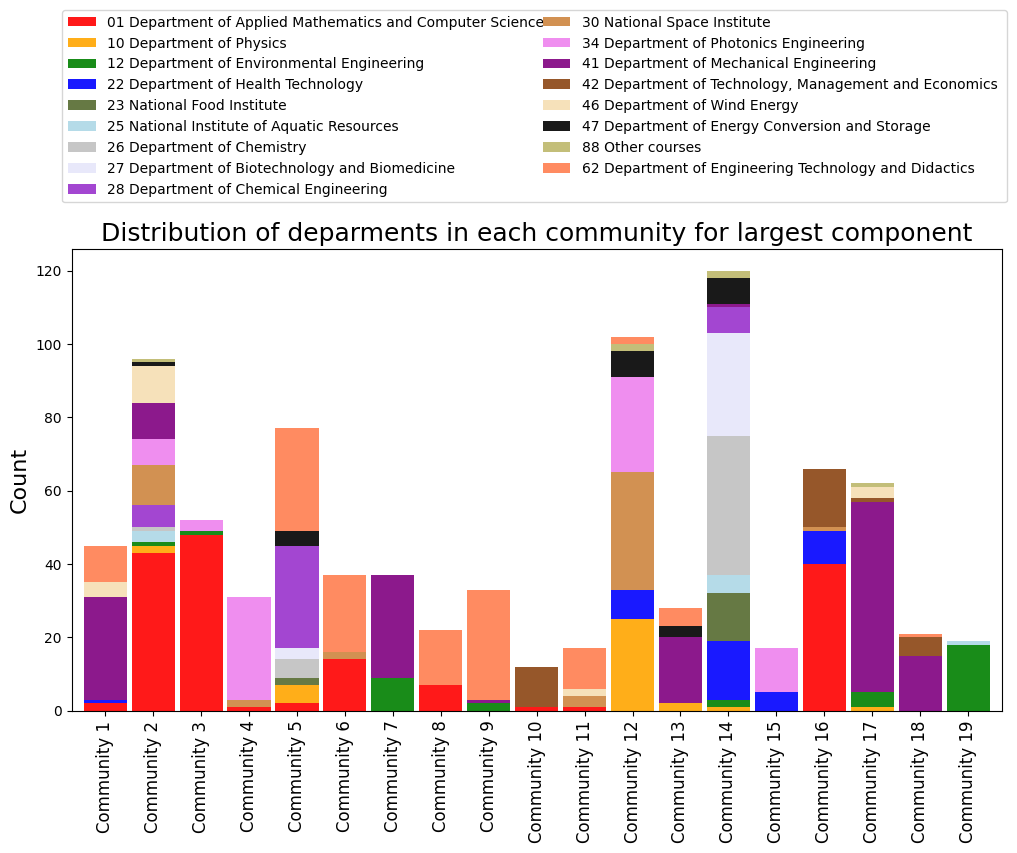

In [41]:
df = pd.DataFrame(community_dict)
df = df.T
plt.rcParams["figure.figsize"] = (12, 6)
df.plot(kind="bar", stacked=True, color = department_palette, width = 0.9, alpha = 0.9) #node_color_com
plt.legend(bbox_to_anchor=(-0.01, 1.1, 1.016, 0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=2)
# plt.legend(bbox_to_anchor=(0, 1.11, 1, 0.2), loc="lower left",
                # mode="expand", borderaxespad=0, ncol=4)
plt.title("Distribution of deparments in each community for largest component", fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel("Count", fontsize=16)
plt.savefig('Pictures/stackedBarPlotCommunities.png',bbox_inches='tight')
plt.show()
plt.close()

**Stacked barplot** Bars represents the 19 communities from from Louvain algorithm. Y-axis shows the count of courses in each community. Stacked bars are colored by departments of the courses in each community.

From the stacked barplot we can see the partition of courses in each community, community 10 and 14 as the smallest and largest respectively. The coloring of the bars shows the different departments at DTU. Some is made up of a few and some quite many.

### Distribution of departments not in largest graph component

We also wanted to look deeper into the distribution of courses and their belonging departments not in the largest component of the network. 

In [42]:
# What is the distribution of the nodes not in largest component?
H = G.to_undirected()
H0 = H
H0.remove_nodes_from(list(nx.isolates(H)))
components = sorted(nx.connected_components(H0), key=len, reverse=True)

# Extract the largest
H0 = H0.subgraph(components[0])

print("Amount of nodes in original graph:", len(list(G.nodes())))
print("Amount of nodes in new graph(largest component):", len(list(H0.nodes())))
print("Amount of isolated nodes removed:", len(list(G.nodes())) - len(list(H0.nodes())))
print("Percentage of nodes removed from graph:", 100-round(len(list(H0.nodes()))/len(list(G.nodes()))*100, 3))

# Get nodes not in largest component
others = components[1:]
others = [list(col) for col in others]
others = [item for sublist in others for item in sublist]
isolated = list(nx.isolates(G))
oi = others + isolated

# Delete values for now
for dep in dep_dict:
    dep_dict[dep] = []

# Make copy of dictionary
dep_dict_all_courses = dep_dict.copy()

# Loop over courses in the oi list
for course in oi:
    try:
        department = G.nodes()[course]['Department']

        # Add if mentioned in community
        dep_dict[department].append(1)
    except KeyError as e:
        pass_ = e

# Sum values in list
for key, vals in dep_dict.items():
    dep_dict[key] = sum(vals)

# Loop over all courses
for course in list(H.nodes()):
    try:
        department = H.nodes()[course]['Department']

        # Add if mentioned in community
        dep_dict_all_courses[department].append(1)
    except KeyError as e:
        pass_ = e

# Sum values in list
for key, vals in dep_dict_all_courses.items():
    dep_dict_all_courses[key] = sum(vals)

Amount of nodes in original graph: 1694
Amount of nodes in new graph(largest component): 894
Amount of isolated nodes removed: 800
Percentage of nodes removed from graph: 47.226


We see that it is almost half of the nodes that is removed from the subgraph, when we only look at the largest graph component. But if we didn't remove the isolated nodes and the minor components, we would get over 700 communities. This is difficult to interpret, so that's why we didn't look at those.  

Below we can see the amount of nodes/courses and their department not in the largest component.

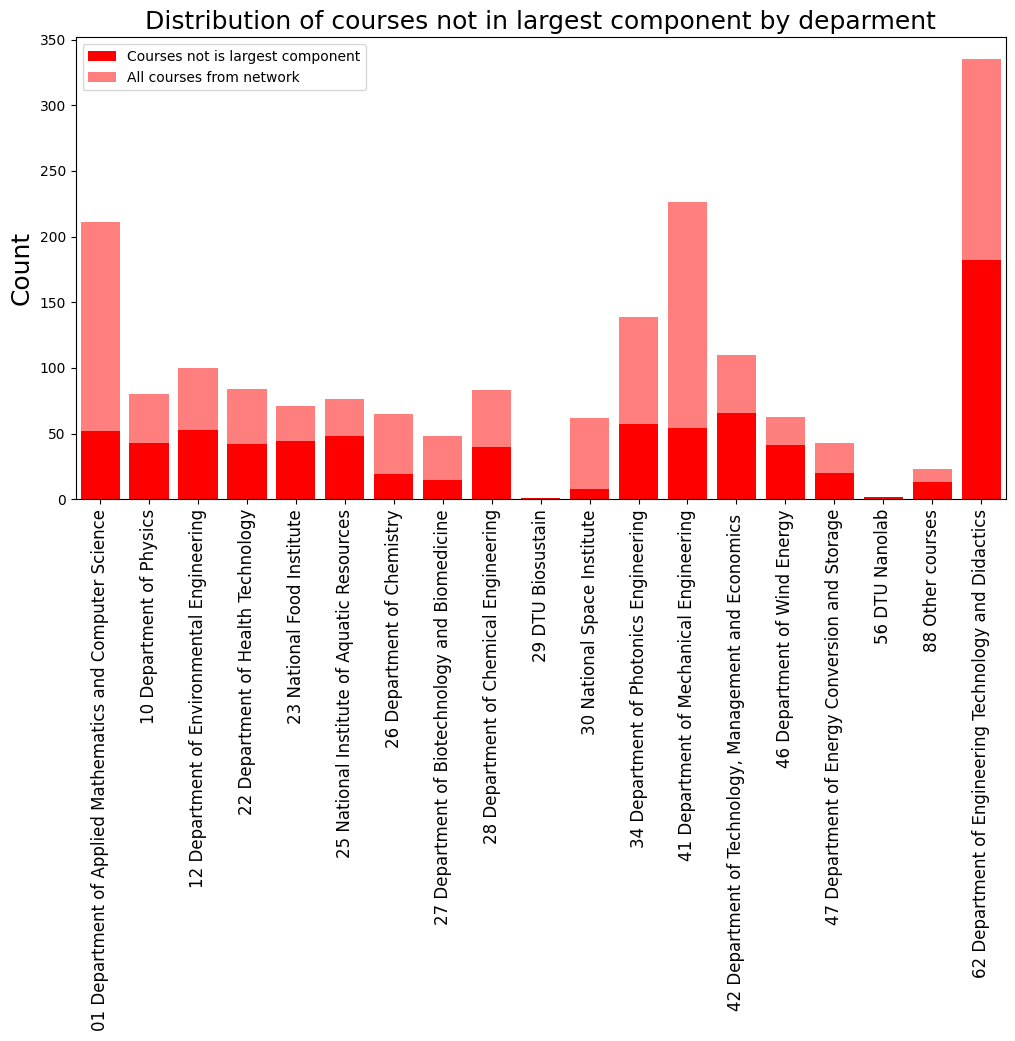

In [43]:
names = list(dep_dict.keys())
values = list(dep_dict.values())
i = 0
for key, vals in dep_dict.items():
    plt.bar(i, vals, tick_label = names[i], label = key, color = department_palette[0])
    try:
        plt.bar(i, dep_dict_all_courses[key], color = department_palette[0], alpha = 0.5) 
    except KeyError as e:
        pass
    i += 1

plt.xticks(range(0,len(names)),names)
# plt.legend(bbox_to_anchor=(-0.01, 1.1, 1.016, 0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=2)
plt.title("Distribution of courses not in largest component by deparment", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.legend(["Courses not is largest component", "All courses from network"])
plt.xlim(left=-0.5, right=18.5)
plt.xticks(fontsize=12, rotation=90)
plt.savefig('Pictures/stackedBarPlotIsolated.png',bbox_inches='tight')
plt.show()
plt.close()

**Bar plot.** Red bars shows the distribution of courses and their departments not being in the largest graph component. Light red colored bars shows count of all courses in network. It shows the 19 departments from DTU, where the Department of Engineering Technology and Didactics is the largest bar in the plot. For DTU Biosustain and DTU Nanolab the amount of courses not in largest component equals all courses from network.

### Conclusional marks on communities

Now we have explored the possible communities of the DTU courses and the departments. In the beginning we found that 5 departments didn't have any courses related to them. In the partition of the network we needed to take only the largest component of the graph in order to get a decent amount of communities, hence we did go from 735 to 19 communities. This number is almost equal to the 17 departments we had left after removal of DTU Biosustain and DTU Nanolab with no courses. Plus with the high modularity we saw this could mean that the network of DTU courses and their departments is parted very nice into 19 smaller communities.  
Therefor we looked further into the distribution of the departments in the found communities. Here we saw that even though the modularity is high, it's not a direct meassure of a perfect partition of what we might thought it could be. A few of the departments did mostly consists of one community else they consist of multiple.  

In the barplot showing amount of courses not in largest component versus all courses in network we saw 2 departments with 1 and 2 courses respectively. We have chosen to keep these department in the further analysis, but they could also have been removed as those departments with no courses at all.

Next up is to keep the thoughts of having these 19 communities and then see if we can distinguish between the communities in some other way by looking at the content for the courses in the communities. We will apply a numerical statistic called term frequency–inverse document frequency (TF-IDF) for the 10 largest communities.

### TF-IDF

We are now going to process the text for the 10 largest communities found above to create a TF-IDF vector for each. This statistical tool is used to detect how important a word is to a text in a collection. 
TF is looking at the frequency of a term adjusted for the length of the text for each community. IDF is determining the weight of rare words in the all texts for all communities. Combined TF-IDF is the importance of a word and it relation to its frequency across documents e.g. communities.

In [44]:
# Sort list of communities by size and select the 10 largest
com_count.sort(key=operator.itemgetter(1), reverse = True)
com10 = sorted(com_list)[0:10]

First we need to extract the content from each course. In the beginning we saved the content as .txt files when using API to load all data about the courses and possible attributes.

In [45]:
# Initialize
course_text = []
course_count = []
tem_text = []
word_count = []
i = 0
lemma = WordNetLemmatizer().lemmatize

# Loop over community
for com in range(len(com10)):
    # Loop over communities
    for c in range(len(com10[com])):
        file_name = com10[com][c]
        i = i + 1
        # print("File", i, "out of", len(com10[comm]))
        try:
            path_to_file = 'course_content/{}.txt'.format(file_name)
            text_file = open(path_to_file, 'r', encoding="utf8").read()
            
            # Set all to lowercase
            text = text_file.split()
            text = [x.lower() for x in text]
            word_count.append(len(text))

            # Append to tem_text for each course
            tem_text.append(text)
        except Exception:
            pass

    # Flat out list of list
    tem_text = [item for sublist in tem_text for item in sublist]

    # Remove stopwords
    tem_text = [word for word in tem_text if word not in stopwords.words('english')]

    # Remove words smaller than 4 characters
    tem_text = [word for word in tem_text if len(word) >= 3]

    # Lemmatize words
    tem_text = [lemma(word) for word in tem_text if len(word) > 3 and word.isalpha()]

    # Print the most frequent words
    counts = Counter(tem_text)

    # Append community text 
    course_text.append(tem_text)
    course_count.append(counts)

    # Reset
    tem_text = []
    i = 0

# Get average word count of course contents
print("Average amount of words in course content:", int(sum(word_count) / len(word_count)))

Average amount of words in course content: 187


Now we have a list of list with words for each community. In order to find the TF-IDF vector for each community we need to find the TF and IDF individually first.

We compute a dictionary with TF where each community is the key with their corresponding dictionary of words as value. The list `idflist` found below contains 10 elements each being a counter dictionary for each community. At last is the TF-IDF found for each community.

In [46]:
# Initialize
counts, idflist = [], []
idf_course_dict = {}
i = 0

# Compute IDF for community texts
for c in range(len(course_text)):
    # Assign dict to list
    counts.append(Counter(course_text[c]))
    idflist.append([Counter(course_text[c])]) # A list for each community being a Counter dict (each)
    idf_course_dict[''.join(["Community ", str(c)])] = computeIDF(Counter(course_text[c]))

In [47]:
# Initalize
tfidf_course = {}
tf_course = None
i = 0

# Compute TF-IDF
for com in range(len(course_text)):
    # TF
    counts = Counter(course_text[com])
    tf_course = computeTF(counts, course_text[com])

    # TF-IDF
    tfidf_course[''.join(["Community ", str(com)])] = computeTFIDF(tf_course, idf_course_dict[''.join(["Community ", str(com)])]) 
    i += 1


In [48]:
# Print words with highest scores for each community
print("Top 5 words for 10 largest communities")
i = 1
for c in range(len(list(tfidf_course))):
    temp_community = list(tfidf_course)[c]
    # Sort scores
    word_and_score = sorted(tfidf_course[temp_community].items(), key=lambda x: x[1], reverse=True)[0:5]
    word = [i[0] for i in word_and_score]
    print("Community ", i, ": ", ', '.join(word), ".", sep = "")
    i += 1

Top 5 words for 10 largest communities
Community 1: course, student, method, process, material.
Community 2: course, student, method, system, model.
Community 3: system, course, student, design, exercise.
Community 4: course, network, communication, system, project.
Community 5: course, process, student, system, chemical.
Community 6: course, programming, student, design, system.
Community 7: security, course, student, system, network.
Community 8: course, data, analysis, student, model.
Community 9: system, power, course, student, control.
Community 10: course, problem, optimization, student, model.


We now have the TF-IDF scores for the 10 largest communities. The higher a scores for a word is, the more important is this for the content. A low score approaching zero will mean the opposite. Above the top 5 words regarding TF-IDF score is printed for the communities. Here we see the words 'course', 'system' and 'security' has highest scores. Looking at the other words some of the same recur such as 'student', 'model' and 'network'.  

In the analysis we want to find words that could be representing this particular community. Some of the top 5 words only occur once such as 'optimization', 'communitcation', 'design', 'programming' and 'power. Important words for the communities is investigated more below using wordclouds.

### Wordclouds

Just above we found the TF-IDF vector for each of the 10 largest communities. Instead of printing the vectors it is more descriptive to use wordclouds for visualization. 

In [49]:
# Initialize
i = 0
wordcloud = []
community = []

for c in range(len(course_text)):
    # Generate titles
    community.append( ' '.join(["Community", str(c+1)]) )

    # Generate a word cloud image
    wordcloud.append( WordCloud(max_font_size = 40, background_color='white', colormap='tab20b').generate_from_frequencies(tfidf_course[''.join(["Community ", str(c)])]))
    i += 1

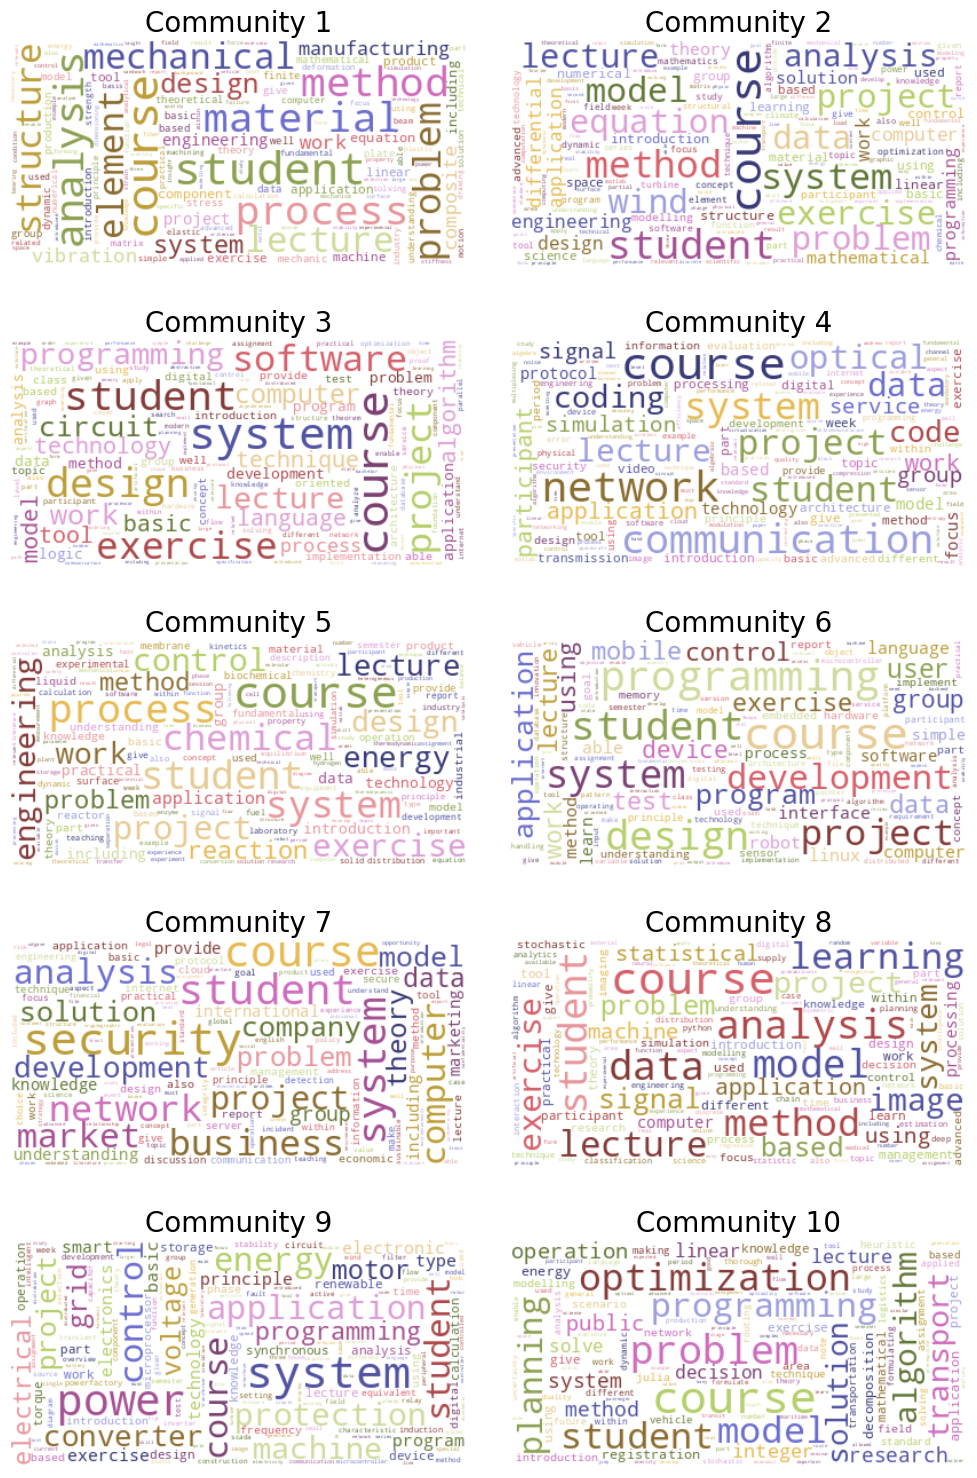

In [50]:
# Create plots side by side
fig, axs = plt.subplots(5,2, figsize=(10,15))
fig.tight_layout(pad=0)

for img, ax, com in zip(wordcloud, axs.reshape(-1), community):
    ax.set_title(com, fontsize = 20)
    ax.imshow(img, interpolation='bilinear')
    ax.axis('off')

plt.savefig('Pictures/wordcloudCommunities.png',bbox_inches='tight')  
plt.show() 
plt.close()

**Wordclouds.** Each wordcloud represent one community of the 10 largest communities. The size of the words vary depending of the TF-IDF score for each. Coloring is added to distinguish the words.

## Conclusional marks

The network of DTU courses have now been thoroughly analyzed through construction, communities, sentiment analysis and evaluation happiness score across course type and size. Since the courses often seem to have more pre-requisites (from in-degrees) than what is actually needed, the network have some flaws according to in-degrees. However, the out-degrees of a node is very informative in order to know what courses that open up opportunities for more courses. The statistics made it clear that around half of the courses do not actually have any prerequisites. These courses are e.g. represented by introductory courses and mandatory courses at your first semesters.

The visualization of the network colored by the belonging department shows that there are a few central departments that offer a great amount of courses offering the fundamental theory needed at a technical university. It is the departments of Applied Mathematics and Computer Science, Physics and Mechanical Engineering.

From the course evaluation it was further discovered that the students participating a Master course was generally more satisfied and happy than the students participating a Bachelor course. Moreover, students attending a 2.5 ECTS points course are generally happier than attending courses of more ECTS points.

A division of the courses into communties made it clear that the courses are connected across departments, since the communities were made from courses of different departments. Wordclouds for the 10 largest communities indicated that the course contents most often contain words as 'course', 'system', 'student', 'model' and 'equation'. More specific words do appear in wordclouds, that could give us an idea of which themes we might expect in the communities.  

This investigation found that there are no significant difference of the happiness level in the course content between the courses offered for Bachelor and Master students. However the investigation found that students generally are happier with the Master courses they follow than the Bachelor courses.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=baf77fd7-8a6f-46ea-a9f3-49866c0b5d34' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>